<a href="https://colab.research.google.com/github/Siddhantdamre/HealthCare/blob/main/Untrainedmodelclustergenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install torch transformers easyocr pdf2image hdbscan pandas matplotlib seaborn scikit-learn django djangorestframework
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Fetched 186 kB in 1s (226 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.6_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.6) ...
Setting up poppler-utils (22.02.0-2ubuntu0.6) ...
Processing triggers for man-db (2.10.2-1) ...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PDF: sample1.pdf, Disease: 3, Time: 78.6631 seconds
PDF: sample2.pdf, Disease: 3, Time: 82.9667 seconds
PDF: sample3.pdf, Disease: 3, Time: 72.1088 seconds
PDF: sample4.pdf, Disease: 3, Time: 80.6564 seconds
PDF: sample5.pdf, Disease: 3, Time: 71.4179 seconds
Average Inference Time: 77.1626 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[{'pin_code': '10001', 'extracted_disease': 3, 'extracted_disease_encoded': 0, 'cluster': -1}, {'pin_code': '10002', 'extracted_disease': 3, 'extracted_disease_encoded': 0, 'cluster': -1}, {'pin_code': '10001', 'extracted_disease': 3, 'extracted_disease_encoded': 0, 'cluster': -1}, {'pin_code': '10003', 'extracted_disease': 3, 'extracted_disease_encoded': 0, 'cluster': -1}, {'pin_code': '10002', 'extracted_disease': 3, 'extracted_disease_encoded': 0, 'cluster': -1}]
plot saved as disease_trends.png


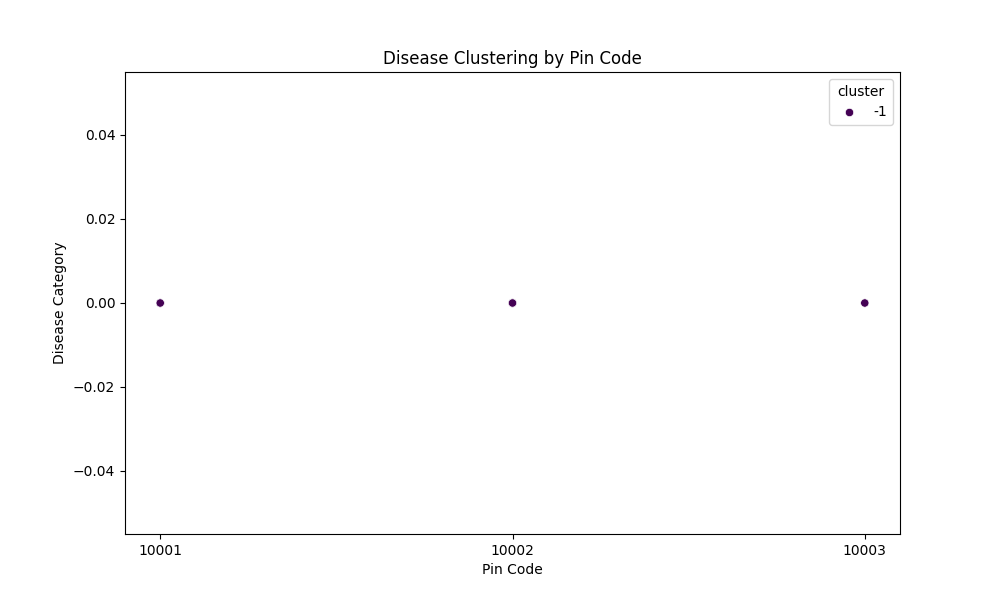

In [6]:
import torch
import easyocr
import hdbscan
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from pdf2image import convert_from_path
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import LabelEncoder
import time
import io
import base64
import os
import numpy as np
from PIL import Image
from IPython.display import Image, display

# Load DistilBERT Model (Optimized for Speed)
class DiseaseClassifier:
    def __init__(self, model_name="distilbert-base-uncased"):
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        self.model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=10)
        self.model.eval()

    def predict_disease(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
        predicted_label = torch.argmax(outputs.logits).item()
        return predicted_label  # Map this to actual disease names

classifier = DiseaseClassifier()

# Faster OCR with EasyOCR
reader = easyocr.Reader(["en"], gpu=torch.cuda.is_available())

def extract_text_from_pdf(pdf_path):
    images = convert_from_path(pdf_path)
    all_text = []
    for image in images:
        image_np = np.array(image)
        result = reader.readtext(image_np)
        page_text = " ".join([entry[1] for entry in result])
        all_text.append(page_text)
    return " ".join(all_text)

def get_disease_trends(pdf_paths, pin_codes):
    data = []
    for pdf_path, pin_code in zip(pdf_paths, pin_codes):
        text = extract_text_from_pdf(pdf_path)
        extracted_disease = classifier.predict_disease(text)
        data.append({"pin_code": pin_code, "extracted_disease": extracted_disease})

    df = pd.DataFrame(data)
    if df.empty:
        print("No data available.")
        return

    label_encoder = LabelEncoder()
    df["extracted_disease_encoded"] = label_encoder.fit_transform(df["extracted_disease"])
    clusterer = hdbscan.HDBSCAN(min_cluster_size=2)  # Corrected min_cluster_size
    df["cluster"] = clusterer.fit_predict(df[["extracted_disease_encoded"]])

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x="pin_code", y="extracted_disease_encoded", hue="cluster", palette="viridis")
    plt.title("Disease Clustering by Pin Code")
    plt.xlabel("Pin Code")
    plt.ylabel("Disease Category")

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image_base64 = base64.b64encode(buf.read()).decode('utf-8')
    plt.close()

    return {"trends": df.to_dict("records"), "plot": image_base64}

def test_performance(pdf_paths):
    total_time = 0
    for pdf_path in pdf_paths:
        start_time = time.time()
        text = extract_text_from_pdf(pdf_path)
        disease = classifier.predict_disease(text)
        end_time = time.time()
        total_time += end_time - start_time
        print(f"PDF: {pdf_path}, Disease: {disease}, Time: {end_time - start_time:.4f} seconds")
    average_time = total_time / len(pdf_paths)
    print(f"Average Inference Time: {average_time:.4f} seconds")

# Sample PDF Paths (Replace with your actual uploaded file names)
sample_pdfs = ["sample1.pdf", "sample2.pdf", "sample3.pdf", "sample4.pdf", "sample5.pdf"]
sample_pin_codes = ["10001", "10002", "10001", "10003", "10002"]

# Run Performance Test
test_performance(sample_pdfs)

# Run Clustering and get plot
results = get_disease_trends(sample_pdfs, sample_pin_codes)
if results:
    print(results["trends"])
    with open("disease_trends.png", "wb") as fh:
        fh.write(base64.b64decode(results['plot']))
    print("plot saved as disease_trends.png")
    display(Image('disease_trends.png'))